In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from astropy.cosmology import LambdaCDM
import astropy.units as u
from extinction import fitzpatrick99
from scipy.optimize import minimize_scalar

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

## 1. The catalogue

In [2]:
bzcat_orig = pd.read_csv('data/BZCAT_combined.csv')  # combined dataset
bzcat = bzcat_orig.copy()  # for further reduction
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,ext_SDSS_u,ext_SDSS_g,ext_SDSS_r,ext_SDSS_i,ext_SDSS_z,ext_PS1_g,ext_PS1_r,ext_PS1_i,ext_PS1_z,ext_PS1_y
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,0.043,0.033,0.023,0.017,0.013,0.032,0.023,0.017,0.013,0.011
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.123,0.096,0.066,0.049,0.037,0.092,0.066,0.049,0.038,0.031
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,0.176,0.137,0.095,0.070,0.052,0.132,0.094,0.070,0.055,0.045


In [3]:
# A cell for reviewing this "wide" dataset by columns

bzcat.iloc[:,80:100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ext_PS1_i  3561 non-null   float64
 1   ext_PS1_z  3561 non-null   float64
 2   ext_PS1_y  3561 non-null   float64
dtypes: float64(3)
memory usage: 83.6 KB


In [4]:
# Dropping unnecessary columns 
bzcat.drop(columns=[
    'PSTARRS_offset', 'GALEX_offset', 'WISE_offset'],
    inplace=True)

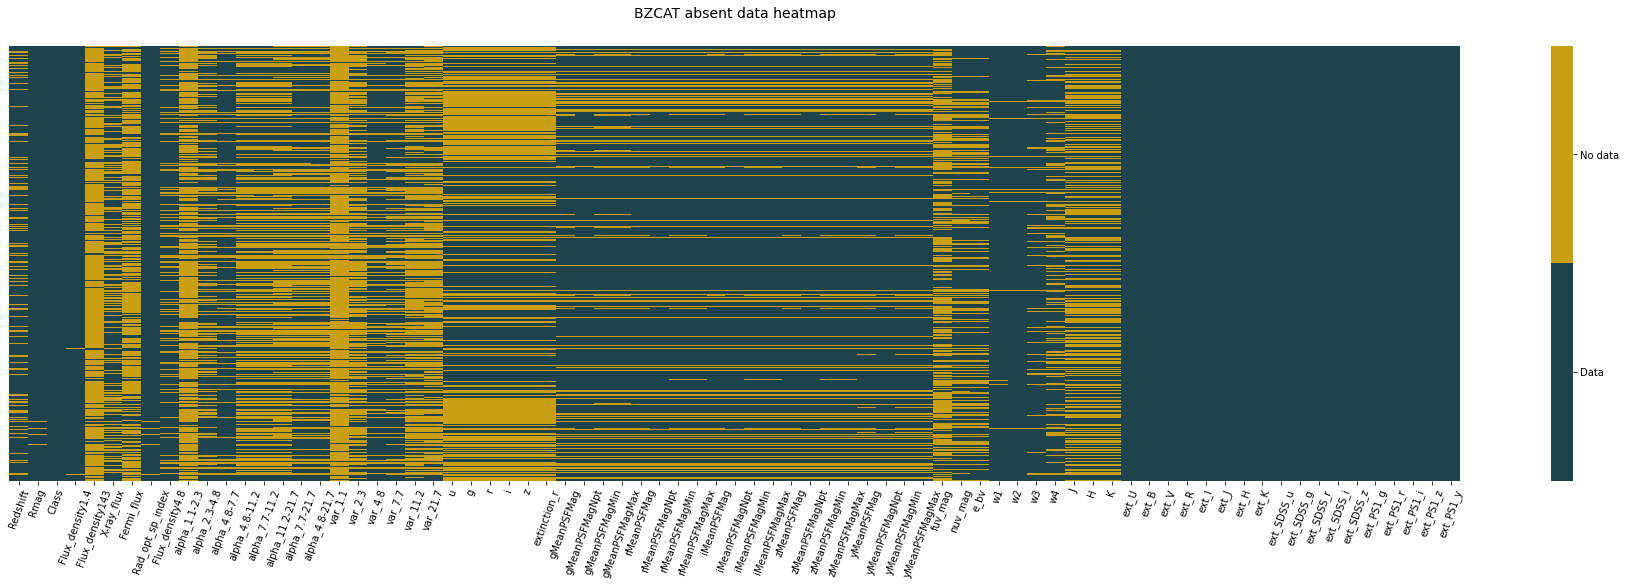

In [5]:
# NaN heatmap

colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    bzcat.iloc[:,3:].isnull(), # All columns except name and coords 
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BZCAT absent data heatmap', y=1.05, fontsize = 14);

***Effective wavelengths***

**GALEX FUV, NUV:** 1538.6, 2315.7 Angstroms (Morrissey et al. 2007, ApJ, 173, 682)

**SDSS ugriz:** 3557, 4702, 6175, 7491, 8946 Angstroms (https://www.astro.ljmu.ac.uk/~ikb/research/mags-fluxes/)

**PanSTARRS grizy:** 4810, 6170, 7520, 8660, 9620 Angstroms (Tonry et al., 2012, ApJ, 750, 99)

**2MASS JHK:** 1.235, 1.662, 2.159 micrometers (IR) (Cohen et al., 2003, AJ, 126, 1090)

**WISE w1-w4:** 3.3526, 4.6028, 11.5608, 22.0883 micrometers (IR) (Jarett et al., 2011, ApJ, 735, 112)

**FIRST**: 20 cm

In [6]:
GALEX_WL = [1538.6, 2315]
SDSS_WL = [3557, 4702, 6175, 7491, 8946]
PSTARRS_WL = [4810, 6170, 7520, 8660, 9620]
TMASS_WL = [12350, 16620, 21590]
WISE_WL = [33526, 46028, 115608, 220883]

---

**Class designations**

7211 - BZQ (Flat Spectrum Radio Quasars)

7300 - BZB (BL Lac)

7309 - BZG (potential BL Lacs showing host galaxy emission dominance over the continuum)

7900 - BZU (uncertain type)

7390 - BZB (BL Lac candidates) 

## 2. Cosmology

In [7]:
""" 
LambdaCDM cosmology with the Planck Collaboration cosmological parameters:

Hubble constant:                      67.74 km s^(-1) Mpc^(-1)
Matter density parameter:             0.3089 (in units of the critical density)
Dark energy density parameter:        0.6911 (in units of the critical density)
CMB temperature:                      2.725 K
Effective number of neutrino species: 3.15
Neutrino mass:                        0.12 eV
Baryon density parameter:             0.0486 (in units of the critical density)
"""

cosmology_lcdm = LambdaCDM(H0=67.74, Om0=0.3089, Ode0=0.6911, Tcmb0=2.725,
                           Neff=3.15, m_nu=0.12, Ob0=0.0486)

Warnings below are because of the NaN values in redshifts

In [8]:
bzcat['universe_age_Gyr'] = bzcat['Redshift'].apply(cosmology_lcdm.age)
bzcat['universe_age_Gyr'] = bzcat['universe_age_Gyr'].apply(lambda x:
    round(float(x / (1 * u.Gyr)), 3))

bzcat['comoving_distance_Mpc'] \
    = bzcat['Redshift'].apply(cosmology_lcdm.comoving_distance)
bzcat['comoving_distance_Mpc'] \
    = bzcat['comoving_distance_Mpc'].apply(lambda x: float(x / (1 * u.Mpc)))
# Because the program gives zeros for NaN redshidts for some reason:
bzcat['comoving_distance_Mpc'] \
    = bzcat['comoving_distance_Mpc'].replace(0, np.NaN)

bzcat['lookback_distance_Mpc'] \
    = bzcat['Redshift'].apply(cosmology_lcdm.lookback_distance)
bzcat['lookback_distance_Mpc'] \
    = bzcat['lookback_distance_Mpc'].apply(lambda x: float(x / (1 * u.Mpc)))
# Because the program gives zeros for NaN redshidts for some reason:
bzcat['lookback_distance_Mpc'] \
    = bzcat['lookback_distance_Mpc'].replace(0, np.NaN)

bzcat['luminosity_distance_Mpc'] \
    = bzcat['Redshift'].apply(cosmology_lcdm.luminosity_distance)
bzcat['luminosity_distance_Mpc'] \
    = bzcat['luminosity_distance_Mpc'].apply(lambda x: float(x / (1 * u.Mpc)))

bzcat['distance_modulus_mag'] = bzcat['Redshift'].apply(cosmology_lcdm.distmod)
bzcat['distance_modulus_mag'] = bzcat['distance_modulus_mag'].apply(lambda x: 
    float(x / (1 * u.mag)))

/home/dkudr/.local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:996: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._lookback_time_integrand_scalar, z, np.inf)[0]


## 3. Right ascention and declination

In [9]:
# RA, Dec: to sines and cosines

FULL_CIRCLE = 1_296_000  # arcseconds in a full circle

def ra_to_arcsec(x):
    hms = x.split()
    return (int(hms[0])*3600+int(hms[1])*60+float(hms[2])) * 15

def del_to_arcsec(x):
    dms = x.split()
    if dms[0][0] == '-':
        return int(dms[0])*3600 - int(dms[1])*60 - float(dms[2])
    else:
        return int(dms[0])*3600 + int(dms[1])*60 + float(dms[2])


bzcat['RA_arcsec'] = bzcat['RA (J2000.0)'].apply(ra_to_arcsec)
bzcat['Dec_arcsec'] = bzcat['Dec (J2000.0)'].apply(del_to_arcsec)

bzcat['RA_sin'] = np.sin(2 * np.pi * bzcat['RA_arcsec'] / FULL_CIRCLE)
bzcat['RA_cos'] = np.cos(2 * np.pi * bzcat['RA_arcsec'] / FULL_CIRCLE)

# I take sin(Dec) because it changes from 1 to -1 at Dec=90 to Dec=-90
# and three coordinates is enough to identify a point on a sphere
bzcat['Dec_sin'] = np.sin(2 * np.pi * bzcat['Dec_arcsec'] / FULL_CIRCLE)

bzcat.drop(['RA_arcsec', 'Dec_arcsec'], 
           inplace=True, axis=1)

bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,ext_PS1_z,ext_PS1_y,universe_age_Gyr,comoving_distance_Mpc,lookback_distance_Mpc,luminosity_distance_Mpc,distance_modulus_mag,RA_sin,RA_cos,Dec_sin
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,...,0.013,0.011,4.847,4016.571161,2722.864905,9126.656771,44.801559,0.001483,0.999999,-0.535094
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.038,0.031,3.181,5353.362866,3233.870858,16260.664058,46.055691,0.004748,0.999989,-0.273152
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,0.055,0.045,2.048,6572.092926,3581.229063,26858.453527,47.145405,0.004990,0.999988,0.329572


## 4. Extinction

The extinctions from the SDSS and NED (the latter based on Schlafly et al., 2011, ApJ, 737, 103) are the same:

In [10]:
bzcat[['extinction_r', 'ext_SDSS_r']].head()

,extinction_r,ext_SDSS_r
0,NaN,0.023
1,NaN,0.066
2,0.09,0.095
3,0.07,0.072
4,0.08,0.078


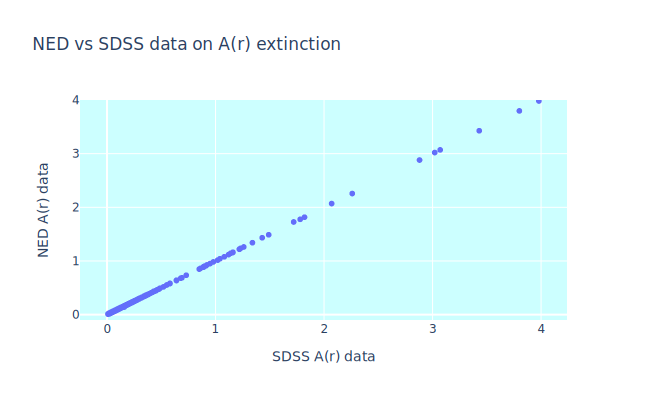

In [11]:
fig = px.scatter(
    bzcat, x='extinction_r', y='ext_SDSS_r',
    width=647, height=400,
    range_y=(-0.1, 4),
    title='NED vs SDSS data on A(r) extinction')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.layout.xaxis.title.text = 'SDSS A(r) data'
fig.layout.yaxis.title.text = 'NED A(r) data'
fig.show('svg')

The $E(B-V)$ from the GALEX and NED data are similar, although a little systematic shift is observed. I'll take the NED data (no missed values)

In [12]:
bzcat['ebv'] = bzcat['ext_B'] - bzcat['ext_V']
bzcat[['e_bv', 'ebv']].head()

,e_bv,ebv
0,0.009960,0.009
1,0.028843,0.026
2,NaN,0.036
3,0.031354,0.028
4,0.033941,0.030


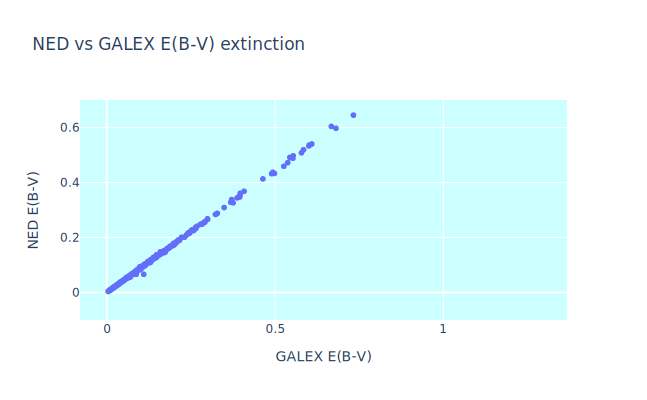

In [13]:
fig = px.scatter(
    bzcat, x='e_bv', y='ebv',
    width=647, height=400,
    range_y=(-0.1, 0.7),
    title='NED vs GALEX E(B-V) extinction')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.layout.xaxis.title.text = 'GALEX E(B-V)'
fig.layout.yaxis.title.text = 'NED E(B-V)'
fig.show('svg')

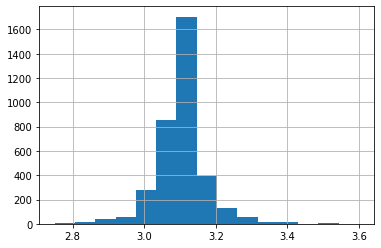

In [14]:
bzcat['rv'] = bzcat['ext_V'] / bzcat['ebv']
bzcat['rv'].hist(bins=15);

The above histogram with the typical $R_V = 3.1$ corresponds to the expected value for the Galaxy

Calculating extinctions for the GALEX fuv, nuv filters from the extinction law (Fitzpatrick, 1999, PASP, 111, 63). Extinction in the WISE w1-w4 filters is about one order of magnitude less than the typical errors

In [15]:
def ext_calc(x):
    extinctions = fitzpatrick99(np.array([1538.6, 2315.7]), 
                                x['ext_V'], x['rv'])
    return pd.Series(extinctions)


bzcat[['ext_fuv', 'ext_nuv']] = bzcat.apply(ext_calc, axis=1) 

## 5. Optical fluxes

In [16]:
# Percent of missing values in optical magnitudes
bzcat[['Rmag', 'fuv_mag', 'nuv_mag', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 
       'zMeanPSFMag', 'yMeanPSFMag', 'u', 'g', 'r', 'i', 'z', 'J', 'H', 'K', 
       'w1', 'w2', 'w3', 'w4']].isnull().mean()

Rmag           0.005055
fuv_mag        0.578208
nuv_mag        0.295142
gMeanPSFMag    0.194889
rMeanPSFMag    0.186184
iMeanPSFMag    0.181410
zMeanPSFMag    0.183095
yMeanPSFMag    0.193204
u              0.455490
g              0.455490
r              0.455490
i              0.455490
z              0.455490
J              0.453805
H              0.453805
K              0.453805
w1             0.015445
w2             0.014603
w3             0.085088
w4             0.288683
dtype: float64

In [17]:
# Dropping BZCAT Rmag - it is not exactly the R magnitude 
# (there are values from other bands according to the authors)
bzcat.drop(columns=['Rmag'], inplace=True)

Calculating $\log_{10}(\nu F_\nu)$ in ${\rm erg} / ({\rm cm}^2\,{\rm s})$

In [18]:
# This is an "operative" version, I'm going to wright a special class for the calculations

def mag2flux(
    data, wl, mag, extinction=None, zeromag_flux=None, units='cgs'):
    
    c = 299_792_458     # speed of light (m/s)
    A2m = 1E-10         # Angstroms to meters
    UNITS_SI = 1E-26    # From 1 Jy = 10^{-26} W*m^{-2}*Hz^{-1}
    UNITS_CGS = 1E-23   # From 1 Jy = 10^{-23} erg*s^{-1}*cm^{-2}*Hz^{-1}
    
    if zeromag_flux==None:
        zeromag_flux = 3631 * np.ones(len(mag))
    if extinction==None:
        extinction = np.zeros((data.shape[0], len(mag)))
    else:
        extinction = np.array(data[extinction])
        
    log_nuflux = np.zeros((data.shape[0], len(mag)))
    nu = np.zeros(len(mag))
    col_out = []
    for i, col in enumerate(mag):           
        col_out.append(col + '_log_nuflux')
        nu[i] = c / (wl[i]*A2m)
        if units=='si':
            log_nuflux[:, i] = np.log10(UNITS_SI * zeromag_flux[i] \
                * 10**((data[col]-extinction[:, i])/-2.5) * nu[i])
        if units=='cgs':
            log_nuflux[:,i] = np.log10(UNITS_CGS * zeromag_flux[i] \
                * 10**((data[col]-extinction[:, i])/-2.5) * nu[i])
    return pd.DataFrame(log_nuflux, columns=col_out), list(np.log10(nu))

In [19]:
# GALEX
mag = ['fuv_mag', 'nuv_mag']
ext = ['ext_fuv', 'ext_nuv']
galex_flux_cols = ['log_nuF_fuv', 'log_nuF_nuv']
bzcat[galex_flux_cols], galex_lognu = mag2flux(
       data=bzcat, wl=GALEX_WL, mag=mag, extinction=ext)
    
# Pan-STARRS 1
mag = ['gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag',
       'zMeanPSFMag', 'yMeanPSFMag']
ext = ['ext_PS1_g', 'ext_PS1_r', 'ext_PS1_i', 'ext_PS1_z', 'ext_PS1_y']
pstarrs_flux_cols = ['log_nuF_g', 'log_nuF_r', 'log_nuF_i', 'log_nuF_z', 'log_nuF_y']
bzcat[pstarrs_flux_cols], pstarrs_lognu = mag2flux(
       data=bzcat, wl=PSTARRS_WL, mag=mag, extinction=ext)

# SDSS
bzcat['u'] = bzcat['u']-0.04  # corr .for AB mag deviation
bzcat['z'] = bzcat['z']+0.02  # corr .for AB mag deviation
mag = ['u', 'g', 'r', 'i', 'z']
ext = ['ext_SDSS_u', 'ext_SDSS_g', 'ext_SDSS_r', 'ext_SDSS_i', 'ext_SDSS_z']
sdss_flux_cols = ['log_nuF_Su', 'log_nuF_Sg', 'log_nuF_Sr', 
             'log_nuF_Si', 'log_nuF_Sz']
bzcat[sdss_flux_cols], sdss_lognu = mag2flux(
       data=bzcat, wl=SDSS_WL, mag=mag, extinction=ext)

# 2MASS
mag = ['J', 'H', 'K']
ext = ['ext_J', 'ext_H', 'ext_K']
zeromag_flux = [1594, 1024, 666.8]
tmass_flux_cols = ['log_nuF_J', 'log_nuF_H', 'log_nuF_K']
bzcat[tmass_flux_cols], tmass_lognu = mag2flux(
    data=bzcat, wl=TMASS_WL, mag=mag, 
    extinction=ext, zeromag_flux=zeromag_flux)

# WISE
mag = ['w1', 'w2', 'w3', 'w4']
zeromag_flux = [309.54, 171.787, 31.674, 8.363]
wise_flux_cols = ['log_nuF_w1', 'log_nuF_w2', 'log_nuF_w3', 'log_nuF_w4']
bzcat[wise_flux_cols], wise_lognu = mag2flux(
       data=bzcat, wl=WISE_WL, mag=mag, zeromag_flux=zeromag_flux)    

Next, I'm playing a bit by drawing the SEDs 

In [20]:
#blcat = blcat[(blcat['Redshift'] > 3.) & (blcat['Redshift'] < 4)].reset_index()

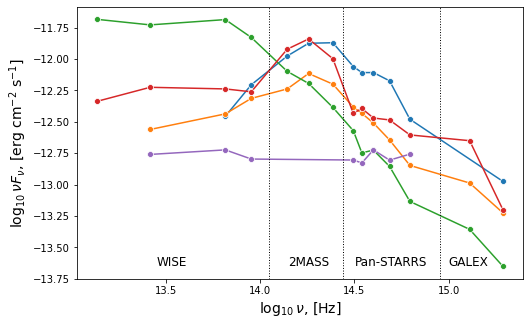

In [21]:
# "Discontinuous" spectra
#start = 50
#j = 0
#for i in range(start, start+10):
#    df = pd.DataFrame({'log_nu': galex_lognu, 'log_nuF': blcat.loc[i, galex_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': pstarrs_lognu, 'log_nuF': blcat.loc[i, pstarrs_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': sdss_lognu, 'log_nuF': blcat.loc[i, sdss_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': tmass_lognu, 'log_nuF': blcat.loc[i, tmass_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    df = pd.DataFrame({'log_nu': wise_lognu, 'log_nuF': blcat.loc[i, wise_flux_cols]})
#    sns.lineplot(data=df, x='log_nu', y='log_nuF', color=sns.color_palette()[j])
#    j += 1

# All filters
#lognu = galex_lognu + pstarrs_lognu + sdss_lognu + tmass_lognu + wise_lognu
#flux_cols = galex_flux_cols + pstarrs_flux_cols + sdss_flux_cols \
#    + tmass_flux_cols + wise_flux_cols

# Withous SDSS
lognu = galex_lognu + pstarrs_lognu + tmass_lognu + wise_lognu
flux_cols = galex_flux_cols + pstarrs_flux_cols \
    + tmass_flux_cols + wise_flux_cols

#flux_cols = ['fuv_mag', 'nuv_mag', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag',
#             'zMeanPSFMag', 'yMeanPSFMag', 'J', 'H', 'K', 'w1', 'w2', 'w3', 'w4']
   
fig, ax = plt.subplots(figsize=(8,5))

start = 5
for i in range(start, start+5):
    df = pd.DataFrame({'log_nu': lognu, 'log_nuF': (bzcat.loc[i, flux_cols])})
    #df.sort_values('log_nu', inplace=True)
    sns.lineplot(data=df, x='log_nu', y='log_nuF', marker='o')
plt.axvline(x=((galex_lognu[-1]+pstarrs_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((pstarrs_lognu[-1]+tmass_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((tmass_lognu[-1]+wise_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
ax.text(13.45, -13.65, 'WISE', fontsize=12)
ax.text(14.15, -13.65, '2MASS', fontsize=12)
ax.text(14.5, -13.65, 'Pan-STARRS', fontsize=12)
ax.text(15, -13.65, 'GALEX', fontsize=12)
plt.xlabel('$\\log_{10} \\nu$, [Hz]', fontsize=14)
plt.ylabel('$\\log_{10} \\nu F_{\\nu}$, [erg cm$^{-2}$ s$^{-1}$]', fontsize=14)
#plt.title('Optical fluxes');
plt.savefig('figs/opt_fluxes.eps', format='eps')

The declination of the SED in the WISE and PanSTARRS regions

In [22]:
def get_tangent(x, y):
    x = np.array(x).astype(float)
    y = np.array(y).astype(float)
    nans = np.isnan(y)
    x = x[~nans]
    y = y[~nans]
    if len(x) < 2:
        return np.NaN
    else:
        xc = x - np.mean(x)
        yc = y - np.mean(y)
        return (xc @ yc) / (xc @ xc)
    

bzcat['tangent_wise'] = bzcat.apply(lambda y: 
    get_tangent(wise_lognu, y[wise_flux_cols]), axis=1)
bzcat['tangent_pstarrs'] = bzcat.apply(lambda y: 
    get_tangent(pstarrs_lognu, y[pstarrs_flux_cols]), axis=1)

Calculating $\log_{10}\nu$ ***in the sourse rest frame*** for different filters

In [23]:
coef = 299_792_458 * 1E10 

bzcat['fuv_lognu'] = np.log10(coef / GALEX_WL[0] * (1+bzcat['Redshift']))
bzcat['nuv_lognu'] = np.log10(coef / GALEX_WL[1] * (1+bzcat['Redshift']))
bzcat['g_lognu'] = np.log10(coef / PSTARRS_WL[0] * (1+bzcat['Redshift']))
bzcat['r_lognu'] = np.log10(coef / PSTARRS_WL[1] * (1+bzcat['Redshift']))
bzcat['i_lognu'] = np.log10(coef / PSTARRS_WL[2] * (1+bzcat['Redshift']))
bzcat['z_lognu'] = np.log10(coef / PSTARRS_WL[3] * (1+bzcat['Redshift']))
bzcat['y_lognu'] = np.log10(coef / PSTARRS_WL[4] * (1+bzcat['Redshift']))
bzcat['J_lognu'] = np.log10(coef / TMASS_WL[0] * (1+bzcat['Redshift']))
bzcat['H_lognu'] = np.log10(coef / TMASS_WL[1] * (1+bzcat['Redshift']))
bzcat['K_lognu'] = np.log10(coef / TMASS_WL[2] * (1+bzcat['Redshift']))
bzcat['w1_lognu'] = np.log10(coef / WISE_WL[0] * (1+bzcat['Redshift']))
bzcat['w2_lognu'] = np.log10(coef / WISE_WL[1] * (1+bzcat['Redshift']))
bzcat['w3_lognu'] = np.log10(coef / WISE_WL[2] * (1+bzcat['Redshift']))
bzcat['w4_lognu'] = np.log10(coef / WISE_WL[3] * (1+bzcat['Redshift']))

Next figure: the SEDS in the rest frame of the sources. The line colors doesn't correspond with the previous figure! This one is only for demonstration. I'm currently going to work in the observer's frame of reference, having the redshifts to be taken into account by the ML models themselves. 

<Figure size 432x288 with 0 Axes>

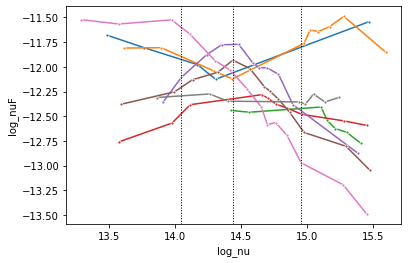

In [24]:
lognu_at_source = [
    'fuv_lognu', 'nuv_lognu', 'g_lognu', 'r_lognu', 'i_lognu','z_lognu', 
    'y_lognu', 'J_lognu', 'H_lognu', 'K_lognu', 'w1_lognu', 'w2_lognu', 
    'w3_lognu', 'w4_lognu'] 
flux_cols = galex_flux_cols + pstarrs_flux_cols \
    + tmass_flux_cols + wise_flux_cols

#flux_cols = ['fuv_mag', 'nuv_mag', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag',
#             'zMeanPSFMag', 'yMeanPSFMag', 'J', 'H', 'K', 'w1', 'w2', 'w3', 'w4']

temp = pd.DataFrame()
for col in flux_cols:
    temp[col] = bzcat[col] + np.log10(1+bzcat['Redshift'])  

start = 0
fig = plt.figure()
plt.figure(facecolor='white')
for i in range(start, start+10):
    df = pd.DataFrame(
        {'log_nu': (bzcat.loc[i, lognu_at_source]).reset_index(drop=True), 
         'log_nuF': (temp.loc[i, flux_cols]).reset_index(drop=True)})
    #df.sort_values('log_nu', inplace=True)
    ax = sns.lineplot(data=df, x='log_nu', y='log_nuF', marker='.')
plt.axvline(x=((galex_lognu[-1]+pstarrs_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((pstarrs_lognu[-1]+tmass_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1)
plt.axvline(x=((tmass_lognu[-1]+wise_lognu[0]) / 2), 
            color='black', linestyle=':', linewidth=1);
#ax.set_title('Blazars at 3 < z < 4\n')

In [25]:
# Removing the frequencies re-calculated for the figure

bzcat.drop(columns=lognu_at_source, inplace=True)

## 6. Radio SED parameters 

In [26]:
seds = pd.read_csv('data/seds_residents.csv')
seds['log_nu'] = np.log10(seds['Frequency (Hz)'])
seds['log_nufnu'] = np.log10(seds['Nufnu (erg cm^-2 s^-1)'])

# "Mutual" source names for the datasets
bzcat['Source'] = bzcat.apply(lambda x:
    x['RA (J2000.0)'][0:2] + x['RA (J2000.0)'][3:5] + x['RA (J2000.0)'][6:8] \
    + x['Dec (J2000.0)'][0:3] + x['Dec (J2000.0)'][4:6] + x['Dec (J2000.0)'][7:9], 
    axis=1)

Conditions:

1. Third-degree polynomial should not grow at high frequences (lognu=15.5)
2. Data both lower and higher lognu=12 should be present

In [27]:
def get_sed_params(s):
    sed = seds[seds['Source'] == s['Source']]
    if len(sed) == 0: # Sometimes the coordinates don't match in Dec arcseconds
        sed = seds[seds['Source'].apply(lambda x: x[:-1]) == s['Source'][:-1]]
               
    low_high_border = 12  # Border between low and high frequences
    limit_pol = 15.5      # Right border for polynomial 
    
    z = s['Redshift']
    if np.isnan(z):
        limit_line = 13   # Right border for linear fit
    else:
        limit_line = 13 - np.log10(1+z)
    
    # Data both lower and higher 'low_high_border' (but lower 'limit_pol') 
    # should be present  
    mask_low = sed['log_nu'] < low_high_border
    mask_high = (sed['log_nu']>low_high_border) & (sed['log_nu']<limit_pol)
    if (len(sed[mask_low])<1) or (len(sed[mask_high])<1):
        #return pd.Series([np.NaN, np.NaN])
        return np.NaN
         
    # Polynomial fit
    def f(x):
        return -(w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3)
    if np.isnan(z):
        sp_max = np.NaN
    else:        
        sed_pol = sed[sed['log_nu'] < limit_pol]
        sed_pol = sed_pol.groupby('log_nu')['log_nufnu'].mean().reset_index()
        
        # A cycle trying to fit a third-degree polynomial
        # If the fit is bad, it removes one point at right  
        sp_max = np.NaN
        while (sed_pol.shape[0] > 3) \
            and (sed_pol[(sed_pol['log_nu']>low_high_border) 
                         & (sed_pol['log_nu']<limit_pol)].shape[0] > 0):
            x0 = np.ones(sed_pol.shape[0])
            x1 = np.array(sed_pol['log_nu'])
            x2 = np.array(sed_pol['log_nu']**2)
            x3 = np.array(sed_pol['log_nu']**3)
            X = np.column_stack((x0, x1, x2, x3))
            y = np.array(sed_pol['log_nufnu'])
            w = np.linalg.inv(X.T@X) @ X.T @ y            
            
            # if third-degree polynomial is ok (if function falls at right):
            if (w[1] + 2*w[2]*limit_pol + 3*w[3]*limit_pol**2) < 0: 
                res = minimize_scalar(
                    f, bounds=(10, limit_pol), method='bounded')
                sp_max = res.x + np.log10(1+z)  
                break 
                               
            sed_pol = sed_pol[:-1]  # remove one point at right
                                              
    # Linear fit
    #sed_line = sed[sed['log_nu'] < limit_line] 
    #sed_line = sed_line.groupby('log_nu')['log_nufnu'].mean().reset_index()
    #if len(sed_line) < 2:
    #        w_line = [np.NaN, np.NaN]
    #else:
    #    x0_line = np.ones(sed_line.shape[0])
    #    x1_line = np.array(sed_line['log_nu'])
    #    X_line = np.column_stack((x0_line, x1_line))
    #    y_line = np.array(sed_line['log_nufnu'])
    #    w_line = np.linalg.inv(X_line.T@X_line) @ X_line.T @ y_line
    
    #if sp_max < 11:
    #    print(s['Source'], z, sp_max)
    #return pd.Series([sp_max, w_line[1]])  
    return sp_max 
     
     
#bzcat[['log_nu_radmax', 'tangent_radio']] \
#    = bzcat.apply(get_sed_params, axis=1)

bzcat['log_nu_radmax'] = bzcat.apply(get_sed_params, axis=1)

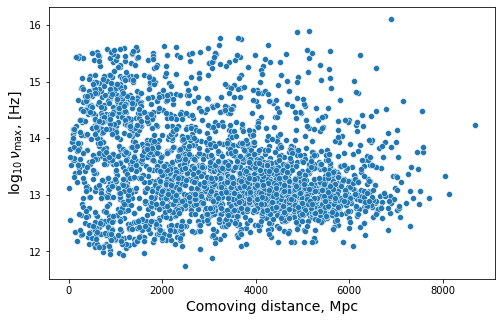

In [28]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=bzcat, x='comoving_distance_Mpc', y='log_nu_radmax')
plt.xlabel('Comoving distance, Mpc', fontsize=14)
plt.ylabel('$\\log_{10} \\nu_{\\rm max}$, [Hz]', fontsize=14)
plt.savefig('figs/synchro_max.eps', format='eps')

In [29]:
bzcat.drop(columns = 'Source', inplace=True)

## 7. Radio spectrum type 

Probably later: not needed for the clustering (categorical variable)

## 8. Optical magnitudes

In [30]:
# Two optical absolute magnitudes. 
# The i magnitude is for the sake of possible approximation of NaN values in w1
# There is no K correction! For the ML modeling purpose only: 
# possible dependencies to fill in the NaNs.

bzcat['i_abs'] = bzcat['iMeanPSFMag'] - bzcat['ext_PS1_i'] - bzcat['distance_modulus_mag']
bzcat['w1_abs'] = bzcat['w1'] - bzcat['distance_modulus_mag']

Let's compare the i and w1 dependencies on distance

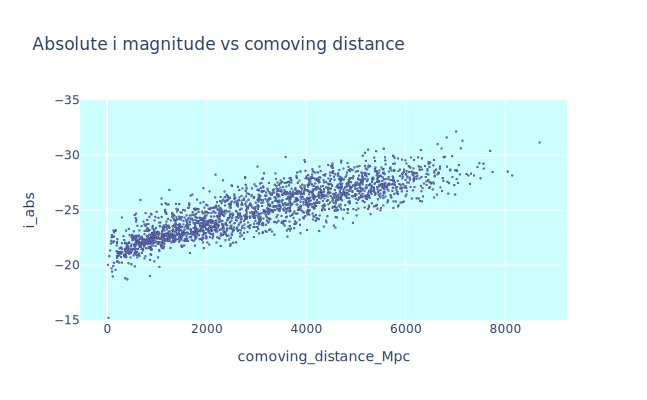

In [31]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='i_abs', #facet_col='Class', 
    bzcat, x='comoving_distance_Mpc', y='i_abs', 
    width=647, height=400,
    range_y=(-15, -35),
    title='Absolute i magnitude vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_yaxes(autorange='reversed')
fig.update_traces(marker_line_width=0.5, marker={'size':2}) #, marker_line_color='white')
fig.show('svg')

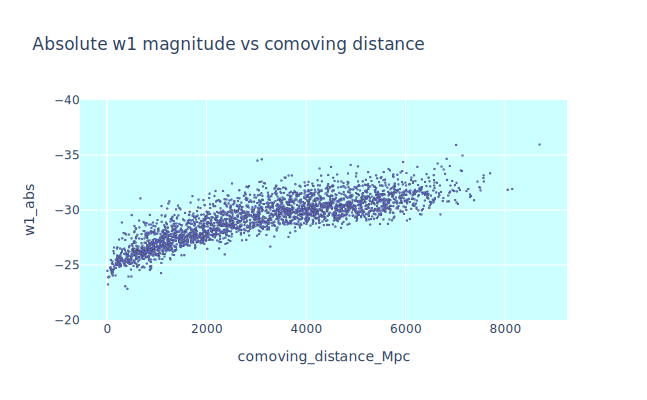

In [32]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='i_abs', #facet_col='Class', 
    bzcat, x='comoving_distance_Mpc', y='w1_abs', 
    width=647, height=400,
    range_y=(-20, -40),
    title='Absolute w1 magnitude vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
#fig.update_yaxes(autorange='reversed')
fig.update_traces(marker_line_width=0.5, marker={'size':2}) #, marker_line_color='white')
fig.show('svg')

## 9. X-ray flux

$L = 4\pi D^2 F$

The flux $F$ in the BZCAT is given in $10^{-12}~{\rm erg} / ({\rm cm}^2\,{\rm s})$ for the 0.1-2.4 keV band (5-124 Angstroms), $D$ is the luminosity distance. We will give the lumonosity in watts and in the logarithmic scale. There is no K-korrection. At the maximum redshift z = 5.3, the emitting band is ~0.8-20 Angstroms (0.6-15 KeV)

In [33]:
Mpc2cm = 3.086e+24  # Mpc to centimeters
# 1e-7 is for conversion from erg/s to W

bzcat['log_X_luminosity_W'] = np.log(4 * np.pi * bzcat['X-ray_flux'] * 1E-12
    * (bzcat['luminosity_distance_Mpc']*Mpc2cm)**2 * 1e-7)

# Recalculating the flux value according to the optical data
bzcat['log_nuF_X'] = np.log10(bzcat['X-ray_flux'] * 1E-12) 

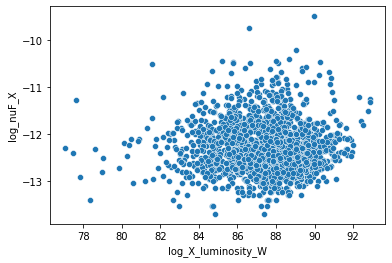

In [34]:
sns.scatterplot(data=bzcat, x='log_X_luminosity_W', y='log_nuF_X');

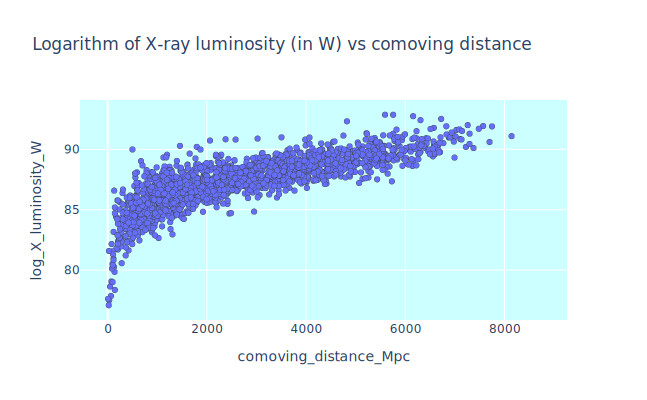

In [35]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='log_X_luminosity_W', #facet_col='Class', 
    bzcat, x='comoving_distance_Mpc', y='log_X_luminosity_W',
    width=647, height=400,
    #range_y=(-35, -15),
    title='Logarithm of X-ray luminosity (in W) vs comoving distance')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

In [36]:
bzcat.drop(columns='X-ray_flux', inplace=True)

## 10. Gamma ray flux

$L = 4\pi D^2 F$

The gamma ray flux $F$ in the BZCAT is given in ${\rm photons} / ({\rm cm}^2\,{\rm s})$ for the 1-100 GeV band (1.2E-7 - 1.2E-5 Angstroms), $D$ is the luminosity distance. We will give the absolute lumonosity in photons per second and in the logarithmic scale. There is no K-korrection. At z = 5.3, the emitting band is 1.9E-8 - 1.9E-6 Angstroms (6.5-650 GeV)

In [37]:
Mpc2cm = 3.086e+24  # Mpc to centimeters

bzcat['log_gamma_luminosity_ph'] = np.log(4 * np.pi * bzcat['Fermi_flux'] 
    * (bzcat['luminosity_distance_Mpc']*Mpc2cm)**2)

# Recalculating the flux value according to the optical data
coef = 1.60218E-12 * 50E9  # 50 GeV to ergs 
bzcat['log_nuF_gamma'] = np.log10(bzcat['Fermi_flux'] * coef)

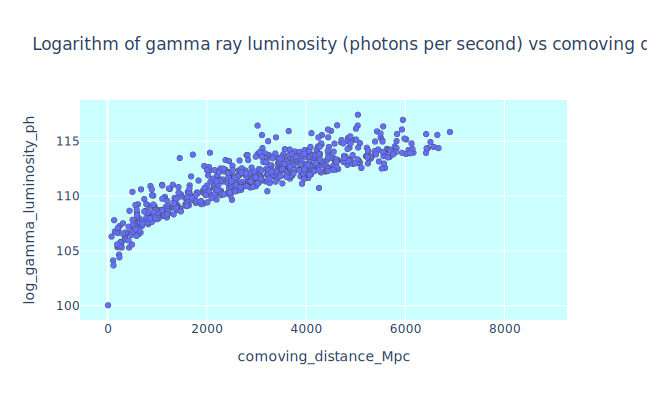

In [38]:
fig = px.scatter(
    bzcat, x='comoving_distance_Mpc', y='log_gamma_luminosity_ph',
    width=647, height=400,
    #range_y=(-35, -15),
    title='Logarithm of gamma ray luminosity (photons per second) vs comoving dist.')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

In [39]:
bzcat.drop(columns='Fermi_flux', inplace=True)

## 11. Radio luminosity

Calculating the luminosities from the dataset and our cosmology. K-correction is implemented: $L_{4.8} = 4\pi D^2 S_{4.8} (1+z)^{-\alpha-1}$, where $S_{4.8}$ is the flux density at 4.8 GHz, $\alpha$ is the average spectral index

In [40]:
Mpc2m = 3.086e+22
UNITS = 1e-29  # From flux density in mJy

bzcat['alpha_temp'] = bzcat.apply(lambda x: x['alpha_4.8-11.2'] 
    if pd.notnull(x['alpha_4.8-11.2']) else x['alpha_4.8-7.7'], axis=1)

bzcat['log_radio_luminosity'] = np.log(4 * np.pi \
    * (bzcat['luminosity_distance_Mpc']*Mpc2m)**2 \
    * bzcat['Flux_density4.8'] * UNITS \
    * (1+bzcat['Redshift'])**(-bzcat['alpha_temp']-1))
    
display(bzcat[['alpha_4.8-11.2', 'alpha_temp',  
               'log_radio_luminosity']].isnull().mean())
bzcat.drop(['alpha_temp'], inplace=True, axis=1)

alpha_4.8-11.2          0.431059
alpha_temp              0.166526
log_radio_luminosity    0.328559
dtype: float64

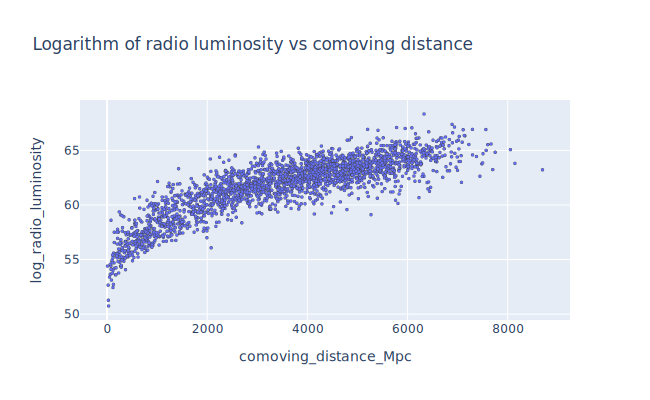

In [41]:
fig = px.scatter(
    #blcat, x='universe_age_Gyr', y='log_radio_luminosity', facet_col='Class', 
    bzcat, x='comoving_distance_Mpc', y='log_radio_luminosity',
    width=650, height=400,
    #range_y=(-35, -15),
    title='Logarithm of radio luminosity vs comoving distance')
#fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5, marker={'size':3}) #, marker_line_color='white')

fig.show('svg')

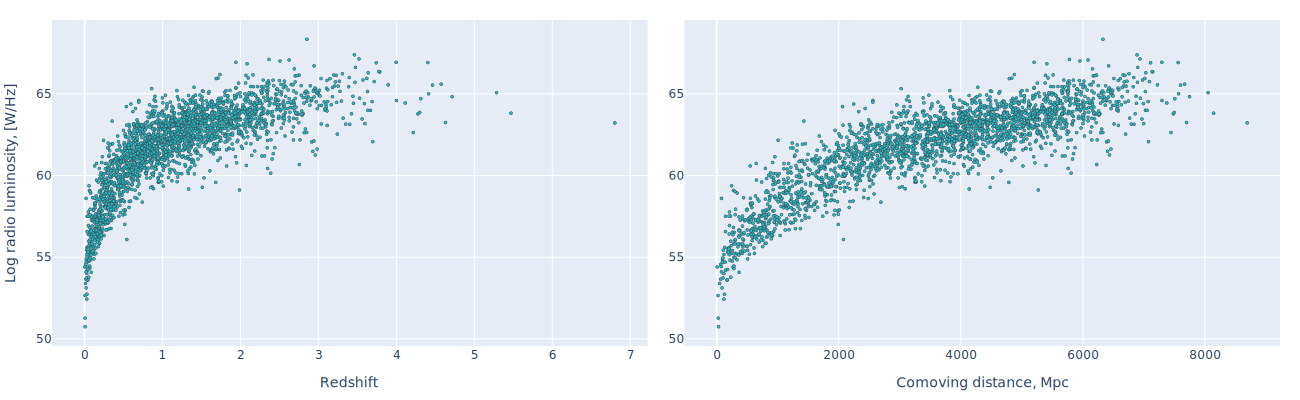

In [42]:
# Paper version

colors = px.colors.DEFAULT_PLOTLY_COLORS

fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0.03)

fig.add_trace(go.Scatter(
    x=bzcat['Redshift'], 
    y=bzcat['log_radio_luminosity'],
    mode='markers',
    marker={'color': colors[9]}
    ), 
    
    1, 1)

fig.add_trace(go.Scatter(
    x = bzcat['comoving_distance_Mpc'], 
    y= bzcat['log_radio_luminosity'],
    mode='markers',
    marker={'color': colors[9]}
    ), 1, 2)

fig.update_traces(marker_line_width=0.5, marker={'size':3})

fig.update_layout(
        showlegend=False, # отображение легенды
        title=None,
        width=1300, # ширина (в пикселях)
        height=400, # высота (в пикселях)
        margin=dict(l=20, r=20, t=20, b=20)
    )

fig.update_xaxes(title_text='Redshift', row=1, col=1)
fig.update_xaxes(title_text='Comoving distance, Mpc', row=1, col=2)
fig.update_yaxes(title_text=r'Log radio luminosity, [W/Hz]', row=1, col=1)

fig.show('svg')
fig.write_image('figs/RLum_Dist.eps')

In [43]:
# Recalculating the flux values according to the optical data

coef = 10E-26  # mJy to erg/(cm s Hz)
bzcat['log_nuF_1.4'] = np.log10(bzcat['Flux_density1.4'] * coef * 1.4E9)
bzcat['log_nuF_143'] = np.log10(bzcat['Flux_density143'] * coef * 143E9)
bzcat['log_nuF_4.8'] = np.log10(bzcat['Flux_density4.8'] * coef * 4.75E9)

In [44]:
bzcat.drop(columns=
    ['Flux_density143', 'Flux_density1.4', 'Flux_density4.8'],
    inplace=True)

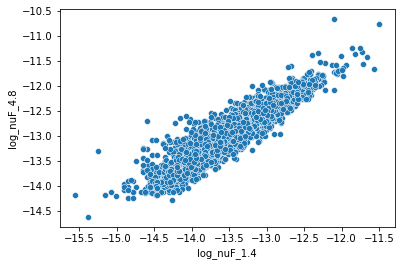

In [45]:
ax = sns.scatterplot(data=bzcat, x='log_nuF_1.4', y='log_nuF_4.8')
#ax.set_ylim([1000, 1100])

In [46]:
flux_cols = ['log_nuF_gamma'] + ['log_nuF_X'] + galex_flux_cols \
    + pstarrs_flux_cols + sdss_flux_cols + tmass_flux_cols + wise_flux_cols \
    + ['log_nuF_143'] + ['log_nuF_4.8'] + ['log_nuF_1.4'] 
    
bzcat[flux_cols].head()

,log_nuF_gamma,log_nuF_X,log_nuF_fuv,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,log_nuF_z,log_nuF_y,log_nuF_Su,...,log_nuF_J,log_nuF_H,log_nuF_K,log_nuF_w1,log_nuF_w2,log_nuF_w3,log_nuF_w4,log_nuF_143,log_nuF_4.8,log_nuF_1.4
0,NaN,-13.301030,NaN,-11.899506,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-12.482644,-12.334411,-12.164664,-12.037379,NaN,-12.659605,-13.137034
1,NaN,NaN,NaN,-12.336429,-11.972098,-12.077398,-12.125891,-12.110271,-12.246688,NaN,...,NaN,NaN,NaN,-12.605844,-12.526411,-12.289864,-12.293380,NaN,-12.839007,-13.312293
2,NaN,NaN,NaN,NaN,-13.387978,-13.275518,-13.238611,-13.154431,-13.019848,-14.146237,...,NaN,NaN,NaN,-13.072645,-13.055211,NaN,NaN,NaN,-13.095420,-13.430626
3,-10.397349,-12.455932,-11.961797,-11.886007,-11.640778,-11.617278,-11.608891,-11.606671,-11.649368,-12.016237,...,-11.856758,-11.83551,-11.825836,-11.638644,-11.652011,-11.750664,-11.734979,NaN,-13.095420,-13.535809
4,NaN,NaN,-12.758931,-12.712343,-12.645858,-12.584398,-12.543171,-12.483111,-12.447248,-12.713037,...,NaN,NaN,NaN,-12.548644,-12.734811,-12.924264,NaN,NaN,-13.633110,-13.808549


## 12. Colors

In [47]:
# Percent of missing values
bzcat[['fuv_mag', 'nuv_mag', 'u', 'g', 'r', 'i', 'z', 'gMeanPSFMag', 
       'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag', 'J', 'H',
       'K', 'w1', 'w2', 'w3', 'w4']].isnull().mean()

fuv_mag        0.578208
nuv_mag        0.295142
u              0.455490
g              0.455490
r              0.455490
i              0.455490
z              0.455490
gMeanPSFMag    0.194889
rMeanPSFMag    0.186184
iMeanPSFMag    0.181410
zMeanPSFMag    0.183095
yMeanPSFMag    0.193204
J              0.453805
H              0.453805
K              0.453805
w1             0.015445
w2             0.014603
w3             0.085088
w4             0.288683
dtype: float64

The colors to calculate: fuv-nuv, nuv-SDSS u, SDSS: (u-g, g-r, r-i, i-z), nuv-PanSTARRS g, PanSTARRS: (g-r, r-i, i-z, z-y), PanSTARRS y - J, J-H, H-K,  K-w1, PanSTARRS y - w1, w1-w2, w2-w3, w3-w4.

Most of the colors are just for further possible approximation of NaN data. Because of many missing values, the GALEX fuv, SDSS, and 2MASS data are to be excluded from the "main" problem solution.

In [48]:
# Calculating the "main" colors
bzcat['nuv-g'] = (bzcat['nuv_mag']-bzcat['ext_nuv']) \
    - (bzcat['gMeanPSFMag']-bzcat['ext_PS1_g'])  # GALEX nuv - PanSTARRS g
bzcat['g-r'] = (bzcat['gMeanPSFMag']-bzcat['ext_PS1_g']) \
    - (bzcat['rMeanPSFMag']-bzcat['ext_PS1_r'])  # PanSTARRS g-r
bzcat['r-i'] = (bzcat['rMeanPSFMag']-bzcat['ext_PS1_r']) \
    - (bzcat['iMeanPSFMag']-bzcat['ext_PS1_i'])  # r-i
bzcat['i-z'] =  (bzcat['iMeanPSFMag']-bzcat['ext_PS1_i']) \
    - (bzcat['zMeanPSFMag']-bzcat['ext_PS1_z'])  # i-z
bzcat['z-y'] = (bzcat['zMeanPSFMag']-bzcat['ext_PS1_z']) \
    - (bzcat['yMeanPSFMag']-bzcat['ext_PS1_y'])  # z-y
bzcat['y-w1'] = (bzcat['yMeanPSFMag']-bzcat['ext_PS1_y']) - bzcat['w1']
bzcat['w1-w2'] = bzcat['w1'] - bzcat['w2']  # WISE w1-w2
bzcat['w2-w3'] = bzcat['w2'] - bzcat['w3']  # w2-w3
bzcat['w3-w4'] = bzcat['w3'] - bzcat['w4']  # w4-w4

# "Auxiliary" colors 
bzcat['fuv-nuv'] = (bzcat['fuv_mag']-bzcat['ext_fuv']) \
    - (bzcat['nuv_mag']-bzcat['ext_nuv'])
bzcat['nuv-Su'] = (bzcat['nuv_mag']-bzcat['ext_nuv']) \
    - (bzcat['u']-bzcat['ext_SDSS_u']) # GALEX nuv - SDSS u
bzcat['Su-Sg'] = (bzcat['u']-bzcat['ext_SDSS_u']) \
    - (bzcat['g']-bzcat['ext_SDSS_g']) # SDSS u-g
bzcat['Sg-Sr'] = (bzcat['g']-bzcat['ext_SDSS_g']) \
    - (bzcat['r']-bzcat['ext_SDSS_r'])  
bzcat['Sr-Si'] = (bzcat['r']-bzcat['ext_SDSS_r']) \
    - (bzcat['i']-bzcat['ext_SDSS_i']) 
bzcat['Si-Sz'] = (bzcat['i']-bzcat['ext_SDSS_i']) \
    - (bzcat['z']-bzcat['ext_SDSS_z']) 
bzcat['y-J'] = (bzcat['yMeanPSFMag']-bzcat['ext_PS1_y']) \
    - (bzcat['J']-bzcat['ext_J'])
bzcat['J-H'] = (bzcat['J']-bzcat['ext_J']) \
    - (bzcat['H']-bzcat['ext_H'])
bzcat['H-K'] = (bzcat['H']-bzcat['ext_H']) \
    - (bzcat['K']-bzcat['ext_K'])
bzcat['K-w1'] = (bzcat['K']-bzcat['ext_K']) - bzcat['w1']

MAIN_COLORS = ['nuv-g', 'g-r', 'r-i', 'i-z', 'z-y', 
               'y-w1', 'w1-w2', 'w2-w3', 'w3-w4']
AUX_COLORS = ['fuv-nuv', 'nuv-Su', 'Su-Sg', 'Sg-Sr', 'Sr-Si', 'Si-Sz',  
              'y-J', 'J-H', 'H-K', 'K-w1']

In [49]:
# Dropping converted columns

bzcat.drop(columns=[
    'extinction_r', 'e_bv', 'ebv', 'rv', 
    # 'ext_fuv', 'ext_nuv',  # To be included in the final dataset
    'ext_U', 'ext_B',
    'ext_V', 'ext_R', 'ext_I', 'ext_J', 'ext_H', 'ext_K', 'ext_SDSS_u',
    'ext_SDSS_g', 'ext_SDSS_r', 'ext_SDSS_i', 'ext_SDSS_z', 'ext_PS1_g',
    'ext_PS1_r', 'ext_PS1_i', 'ext_PS1_z', 'ext_PS1_y', 'fuv_mag', 'nuv_mag',
    'u', 'g', 'r', 'i', 'z', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 
    'zMeanPSFMag', 'yMeanPSFMag', 'w1',  'w2','w3', 'w4', 'J', 'H', 'K'
    ], 
    inplace=True)

## 13. Variability

In [50]:
# MinMax differences

bzcat['g_var'] = bzcat['gMeanPSFMagMax'] - bzcat['gMeanPSFMagMin']
bzcat['r_var'] = bzcat['rMeanPSFMagMax'] - bzcat['rMeanPSFMagMin']
bzcat['i_var'] = bzcat['iMeanPSFMagMax'] - bzcat['iMeanPSFMagMin']
bzcat['z_var'] = bzcat['zMeanPSFMagMax'] - bzcat['zMeanPSFMagMin']
bzcat['y_var'] = bzcat['yMeanPSFMagMax'] - bzcat['yMeanPSFMagMin']

In [51]:
# Correlation between optical variabilities
bzcat[['g_var', 'r_var', 'i_var', 'z_var', 'y_var']].corr()

,g_var,r_var,i_var,z_var,y_var
g_var,1.000000,0.393185,0.411795,0.366214,0.292777
r_var,0.393185,1.000000,0.450459,0.378210,0.306273
i_var,0.411795,0.450459,1.000000,0.430385,0.362752
z_var,0.366214,0.378210,0.430385,1.000000,0.422810
y_var,0.292777,0.306273,0.362752,0.422810,1.000000


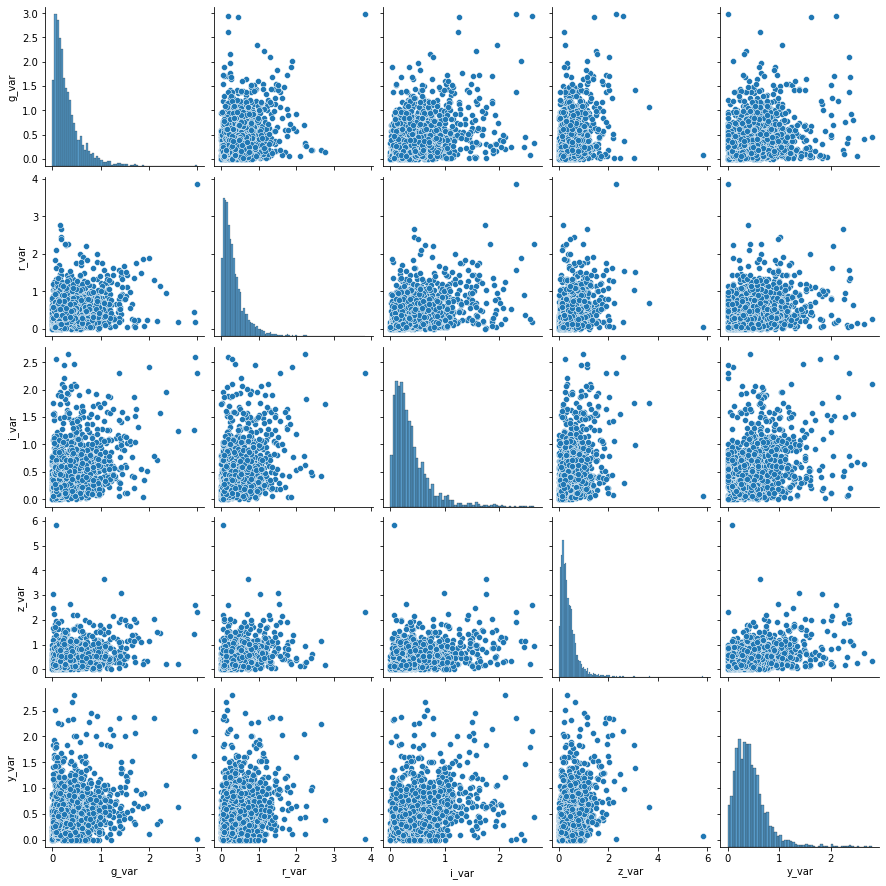

In [52]:
sns.pairplot(bzcat[['g_var', 'r_var', 'i_var', 'z_var', 'y_var']]);

In [53]:
# Correlation between radio variabilities
bzcat[['var_21.7', 'var_11.2', 'var_7.7', 'var_4.8']].corr()

,var_21.7,var_11.2,var_7.7,var_4.8
var_21.7,1.000000,0.441117,0.338111,0.363630
var_11.2,0.441117,1.000000,0.335642,0.478655
var_7.7,0.338111,0.335642,1.000000,0.421880
var_4.8,0.363630,0.478655,0.421880,1.000000


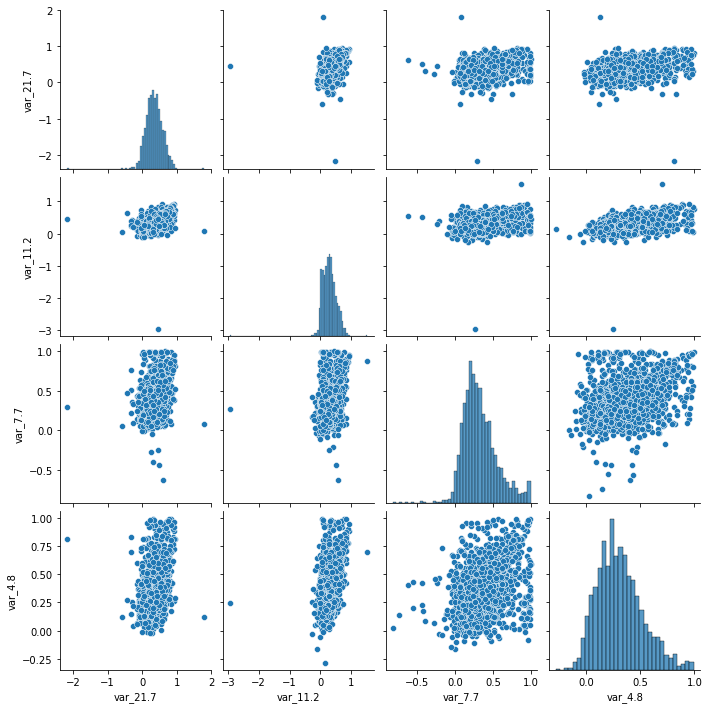

In [54]:
sns.pairplot(bzcat[['var_21.7', 'var_11.2', 'var_7.7', 'var_4.8']]);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


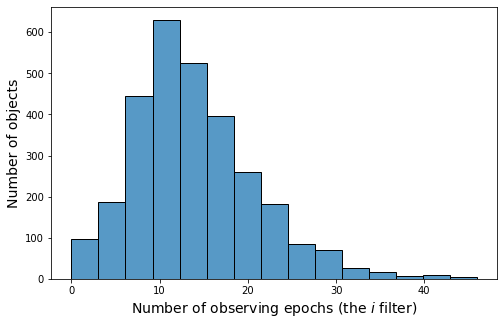

In [55]:
# PanSTARRS typical number of observations
plt.figure(figsize=(8, 5))
sns.histplot(data=bzcat, x='iMeanPSFMagNpt', bins=15)
plt.xlabel('Number of observing epochs (the $i$ filter)', fontsize=14)
plt.ylabel('Number of objects', fontsize=14)
plt.savefig('figs/pstarrs_nobs.eps', format='eps')

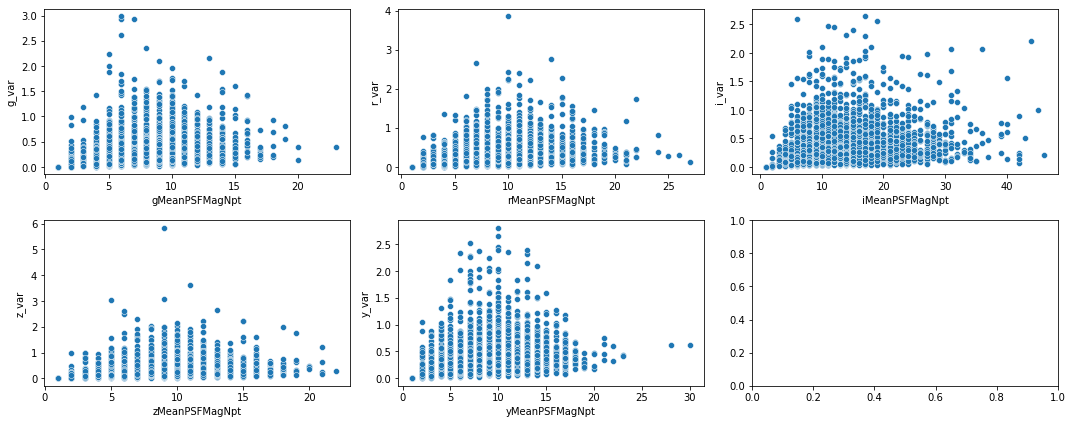

In [56]:
# Variability vs number of measuremets

fig, ax = plt.subplots(2, 3, figsize=(15,6))
sns.scatterplot(x=bzcat['gMeanPSFMagNpt'], y=bzcat['g_var'], ax=ax[0,0])
sns.scatterplot(x=bzcat['rMeanPSFMagNpt'], y=bzcat['r_var'], ax=ax[0,1])
sns.scatterplot(x=bzcat['iMeanPSFMagNpt'], y=bzcat['i_var'], ax=ax[0,2])
sns.scatterplot(x=bzcat['zMeanPSFMagNpt'], y=bzcat['z_var'], ax=ax[1,0])
sns.scatterplot(x=bzcat['yMeanPSFMagNpt'], y=bzcat['y_var'], ax=ax[1,1])
fig.tight_layout()

A quasi-normal distribution is seen. The right wing with a greater number of observations shows a variability descent most probably because of a fewer number of objects, given that higher variabilities are not often. I'll take all measurements of ${\rm var} = m_{\rm max} - m_{\rm min}$ where the measurements number > 1. 

In [57]:
def var2nan(x):
    if x['gMeanPSFMagNpt']==0 or x['gMeanPSFMagNpt']==1:
        x['g_var'] = np.NaN
    if x['rMeanPSFMagNpt']==0 or x['rMeanPSFMagNpt']==1:
        x['r_var'] = np.NaN
    if x['iMeanPSFMagNpt']==0 or x['iMeanPSFMagNpt']==1:
        x['i_var'] = np.NaN
    if x['zMeanPSFMagNpt']==0 or x['zMeanPSFMagNpt']==1:
        x['z_var'] = np.NaN
    if x['yMeanPSFMagNpt']==0 or x['yMeanPSFMagNpt']==1:
        x['y_var'] = np.NaN
    return x
        

bzcat = bzcat.apply(var2nan, axis=1)        

In [58]:
# Dropping converted columns

bzcat.drop(columns=[
    'gMeanPSFMagNpt', 'gMeanPSFMagMin', 'gMeanPSFMagMax',
    'rMeanPSFMagNpt', 'rMeanPSFMagMin', 'rMeanPSFMagMax',
    'iMeanPSFMagNpt', 'iMeanPSFMagMin', 'iMeanPSFMagMax',
    'zMeanPSFMagNpt', 'zMeanPSFMagMin', 'zMeanPSFMagMax',
    'yMeanPSFMagNpt', 'yMeanPSFMagMin', 'yMeanPSFMagMax'],
    inplace=True
)

## 14. Classes

**Class designations**

7211 - BZQ (Flat Spectrum Radio Quasars)

7300 - BZB (BL Lac)

7309 - BZG (potential BL Lacs showing host galaxy emission dominance over the continuum)

7900 - BZU (uncertain type)

7390 - BZB (BL Lac candidates) 

In [59]:
bzcat['Class'].replace({
    7211: 'BZQ', 7300: 'BLLac', 7309: 'BZG', 7900: 'BZU', 7390: 'BLLac_c'}, 
    inplace=True)

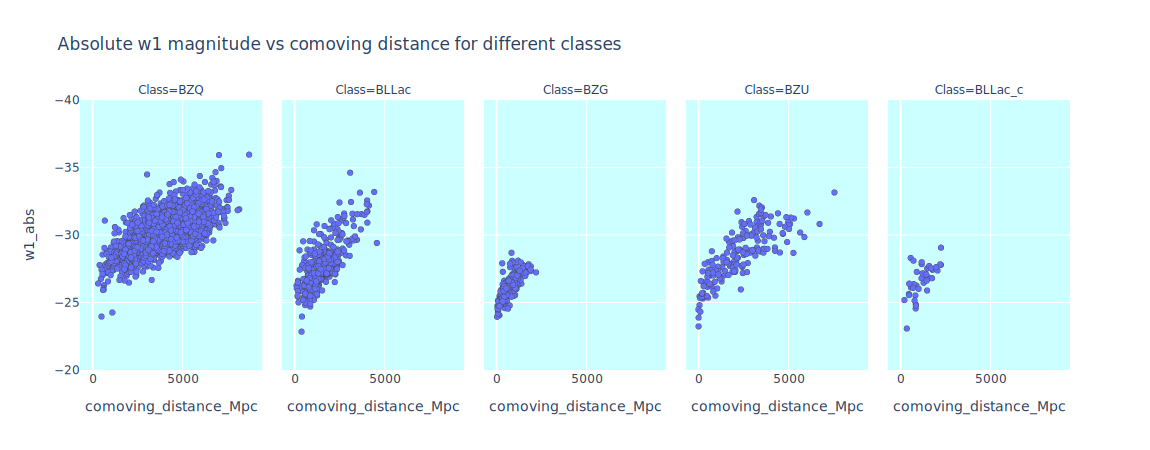

In [60]:
fig = px.scatter(bzcat, x='comoving_distance_Mpc', y='w1_abs', facet_col='Class', 
                 range_y=(-20,-40), width=1150, height=450,
                 title='Absolute w1 magnitude vs comoving distance for different classes')
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.update_traces(marker_line_width=0.5) #, marker_line_color='white')
fig.show('svg')

Different dependencies for different classes? Or different distributions along the distance?

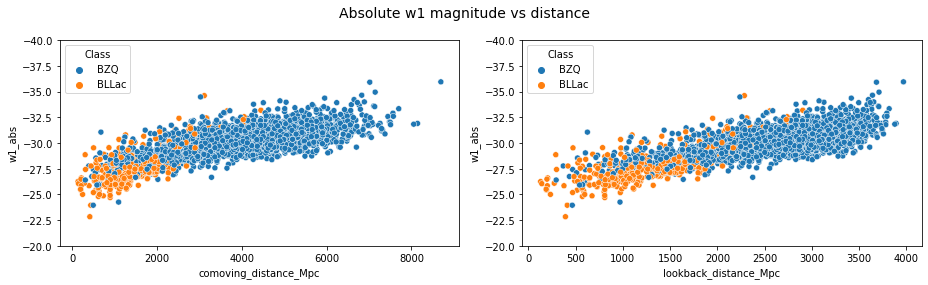

In [61]:
mask = (bzcat['Class']=='BZQ') | (bzcat['Class']=='BLLac')

fig, ax = plt.subplots(1, 2, figsize=(13,4))
sns.scatterplot(data=bzcat[mask], x='comoving_distance_Mpc', y='w1_abs', 
                hue='Class', ax=ax[0])
sns.scatterplot(data=bzcat[mask], x='lookback_distance_Mpc', y='w1_abs', 
                hue='Class', ax=ax[1])
ax[0].set_ylim(-20, -40)
ax[1].set_ylim(-20, -40)
fig.suptitle('Absolute w1 magnitude vs distance', fontsize=14)
fig.tight_layout()

No OneHotEncoding for the classes here. Previous experiments have shown that the inclusion of these features in the clustering calculations leads to trivial results.

## 15. Hardness

I'm selecting independent "hardnesses", which are calculated as $\log_{10} \frac{\nu_1 F_1}{\nu_2 F_2}$.

In [62]:
# The old version: ratios of logarithms (not exactly physical)

#bzcat['Radio_radio_hard'] = bzcat['log_nuF_1.4'] / bzcat['log_nuF_4.8'] # jet/jet
#bzcat['Radio_IR_hard'] = bzcat['log_nuF_1.4'] / bzcat['log_nuF_w2'] # jet/thorus
#bzcat['IR_opt_hard'] = bzcat['log_nuF_w2'] / bzcat['log_nuF_i'] # thorus/acc.disk
#bzcat['Opt_UV_hard'] = bzcat['log_nuF_i'] / bzcat['log_nuF_nuv'] # acc.disk/acc.disk
#bzcat['IR_X_hard'] = bzcat['log_nuF_w2'] / bzcat['log_nuF_X'] # thorus/acc.disk corona

In [63]:
bzcat['Radio_radio_hard'] = bzcat['log_nuF_1.4'] - bzcat['log_nuF_4.8']  # jet/jet
#bzcat['Radio_IR_hard'] = bzcat['log_nuF_1.4'] - bzcat['log_nuF_w2']
#bzcat['Radio_opt_hard'] = bzcat['log_nuF_1.4'] - bzcat['log_nuF_i']
#bzcat['Radio_UV_hard'] = bzcat['log_nuF_1.4'] - bzcat['log_nuF_nuv']
#bzcat['Radio_X_hard'] = bzcat['log_nuF_1.4'] - bzcat['log_nuF_X']

bzcat['IR_opt_hard'] = bzcat['log_nuF_w2'] - bzcat['log_nuF_i']  # thorus/acc.disk
bzcat['IR_UV_hard'] = bzcat['log_nuF_w2'] - bzcat['log_nuF_nuv']  # thorus/acc.disk
bzcat['IR_X_hard'] = bzcat['log_nuF_w2'] - bzcat['log_nuF_X']  # thorus/acc.disk corona

#bzcat['Opt_UV_hard'] = bzcat['log_nuF_i'] - bzcat['log_nuF_nuv']
#bzcat['Opt_X_hard'] = bzcat['log_nuF_i'] - bzcat['log_nuF_X']

#bzcat['UV_X_hard'] = bzcat['log_nuF_nuv'] - bzcat['log_nuF_X']

#hardnesses = [
#   'Rad_opt_sp_index',
#    'Radio_radio_hard', 'Radio_IR_hard', 'Radio_opt_hard', 
#    'Radio_UV_hard','Radio_X_hard', 'IR_opt_hard', 'IR_UV_hard', 
#    'IR_X_hard', 'Opt_UV_hard', 'Opt_X_hard', 'UV_X_hard'
#]
hardnesses = [
    'Rad_opt_sp_index',
    'Radio_radio_hard',
    'IR_opt_hard', 'IR_UV_hard', 
    'IR_X_hard'
]

In [64]:
bzcat[hardnesses].corr()

,Rad_opt_sp_index,Radio_radio_hard,IR_opt_hard,IR_UV_hard,IR_X_hard
Rad_opt_sp_index,1.000000,-0.008317,0.402119,0.150391,0.229657
Radio_radio_hard,-0.008317,1.000000,-0.084705,-0.055995,-0.045605
IR_opt_hard,0.402119,-0.084705,1.000000,0.489014,0.432467
IR_UV_hard,0.150391,-0.055995,0.489014,1.000000,0.381800
IR_X_hard,0.229657,-0.045605,0.432467,0.381800,1.000000


In [65]:
bzcat.to_csv('./data/BZCAT_all_features.csv', index=False)